# Generating normally distributed values, no tears

This notebook shows how to generate values from a normal (Gaussian) distribution. There are three main algorithms that are covered.

* Box-Muller transform
* Marsaglia-Tsang
* Ziggurat

The Box-Muller and Marsaglia-Tsang algorithms are very similar in shape and form. Box-Muller operates in polar coordinates while Marsaglia-Tsang operates in Cartesian coordinates. All three algorithms sample for points and test for rejection/acceptance. Box-Muller and Marsaglia-Tsang sample for points within the unit square while Ziggurat samples based on stacked rectangles covering half of the normal distribution. The Ziggurat algorithm is the fastest, followed by Marsaglia-Tsang and then Box-Muller.

We simply implement all three algorithms in this notebook and compare the outputs to `numpy`. 

In [1]:
%matplotlib inline
import sys
import time
import ctypes
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(37)
sns.set(color_codes=True)
num_samples = 10000

def box_muller(m, std):
    epsilon = sys.float_info.min
    two_pi = 2.0 * np.pi
    
    u1 = 0.0
    u2 = 0.0
    
    while True:
        u1 = np.random.rand()
        u2 = np.random.rand()
        if u1 > epsilon:
            break
    
    z0 = np.sqrt(-2.0 * np.log(u1)) * np.cos(two_pi * u2)
    z1 = np.sqrt(-2.0 * np.log(u1)) * np.sin(two_pi * u2)
    
    return m + std * z0

def marsaglia_tsang(m, std):
    u = 0.0
    v = 0.0
    s = 0.0
    
    while True:
        u = np.random.rand() * 2.0 - 1.0
        v = np.random.rand() * 2.0 - 1.0
        s = np.power(u, 2.0) + np.power(v, 2.0)
        if 0.0 < s and s <= 1.0:
            break
    
    z = np.sqrt(-2.0 * np.log(s) / s)
    return m + std * u * z

Although the Ziggurat algorithm is the fastest, it is not the easiest to understand or implement. The implementation here is a [translation from JavaScript](https://www.filosophy.org/post/35/normaldistributed_random_values_in_javascript_using_the_ziggurat_algorithm/) (which was itself a translation from [C](https://www.jstatsoft.org/v05/i08/supp/1), dead link). Note all the low-level bitwise operations.

In [2]:
class Ziggurat(object):
    def __init__(self, mean=0.0, std=1.0, seed=37):
        self.mean = mean
        self.std = std
        self.wn = np.array([0.0 for i in range(128)], dtype=np.float)
        self.fn = np.array([0.0 for i in range(128)], dtype=np.float)
        self.kn = np.array([0.0 for i in range(128)], dtype=np.float)
        
        self.jsr = 123456789 ^ (seed if seed is not None else int(time.time()))
    
        m1 = 2147483648.0
        dn = 3.442619855899
        tn = dn
        vn = 9.91256303526217e-3
        
        q = vn / np.exp(-0.5 * dn * dn)
        self.kn[0] = np.floor((dn / q) * m1)
        self.kn[1] = 0
        
        self.wn[0] = q / m1
        self.wn[127] = dn / m1
        
        self.fn[0] = 1.0
        self.fn[127] = np.exp(-0.5 * dn * dn)
        
        i = 126
        while i >= 1:
            dn = np.sqrt(-2.0 * np.log(vn / dn + np.exp(-0.5 * dn * dn)))
            self.kn[i+1] = np.floor((dn / tn) * m1)
            tn = dn
            self.fn[i] = np.exp(-0.5 * dn * dn)
            self.wn[i] = dn / m1
            
            i -= 1        
        
    def shr3(self):
        def rshift(val, n): 
            if val >= 0:
                return ctypes.c_int(val >> n).value
            else:
                return ctypes.c_int((val+0x100000000) >> n).value

        jz = self.jsr
        jzr = self.jsr
        jzr = ctypes.c_int(jzr ^ (jzr << 13)).value
        jzr = ctypes.c_int(jzr ^ rshift(jzr, 17)).value
        jzr = ctypes.c_int(jzr ^ (jzr << 5)).value
        self.jsr = jzr
        return ctypes.c_int((jz+jzr) | 0).value

    def uni(self):
        return 0.5 * (1.0 + self.shr3() / -np.power(2, 31))
    
    def uni_safe(self):
        while True:
            u = self.uni()
            if 0 != u:
                return u

    def rnorm(self):
        hz = self.shr3()
        iz = hz & 127
        return self.mean + self.std * (hz * self.wn[iz] if np.abs(hz) < self.kn[iz] else self.nfix(hz, iz))

    def nfix(self, hz, iz):
        r = 3.442619855899
        r1 = 1.0 / r
        x = 0
        y = 0

        while True:
            x = hz * self.wn[iz]
            if iz == 0:
                x = -np.log(self.uni_safe()) * r1
                y = -np.log(self.uni_safe())

                while True:
                    x = -np.log(self.uni_safe()) * r1
                    y = -np.log(self.uni_safe())
                    if y + y >= x * x:
                        break
                return r + x if hz > 0 else -r - x

            if self.fn[iz] + self.uni() * (self.fn[iz-1] - self.fn[iz]) < np.exp(-0.5 * x * x):
                return x

            hz = self.shr3()
            iz = hz & 127

            if np.abs(hz) < self.kn[iz]:
                return hz * self.wn[iz]

# Execute the sampling from each method

In [3]:
num_samples = 10000

mean = 0
std = 1
zigg = Ziggurat(mean=mean, std=std)

np_samples = np.random.normal(mean, std, num_samples)
bm_samples = np.array([box_muller(mean, std) for _ in range(num_samples)])
mt_samples = np.array([marsaglia_tsang(mean, std) for _ in range(num_samples)])
zi_samples = np.array([zigg.rnorm() for _ in range(num_samples)])

# Plot the densities of the samples from each method

Text(0.5,1,'Ziggurat')

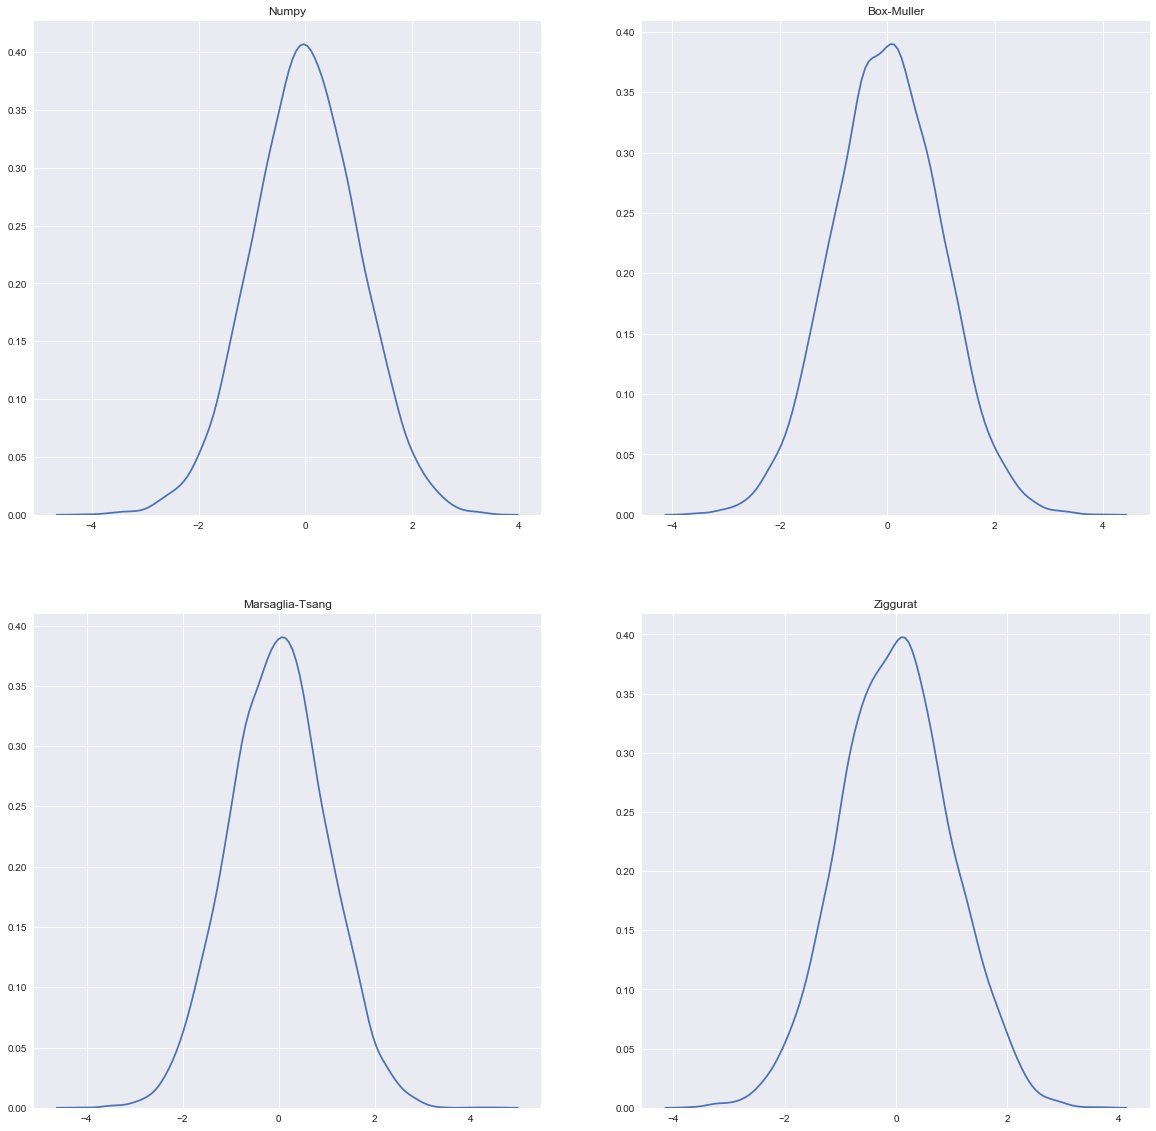

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20), sharex=False, sharey=False)

sns.kdeplot(np_samples, ax=ax[0, 0])
sns.kdeplot(bm_samples, ax=ax[0, 1])
sns.kdeplot(mt_samples, ax=ax[1, 0])
sns.kdeplot(zi_samples, ax=ax[1, 1])

ax[0, 0].set_title('Numpy')
ax[0, 1].set_title('Box-Muller')
ax[1, 0].set_title('Marsaglia-Tsang')
ax[1, 1].set_title('Ziggurat')

# References

* [Box-Muller Transform](https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform)
* [Marsaglia Polar Method](https://en.wikipedia.org/wiki/Marsaglia_polar_method)
* [Ziggurat Algorithm](https://en.wikipedia.org/wiki/Ziggurat_algorithm)
* [C++ Numeric Limits](http://en.cppreference.com/w/cpp/types/numeric_limits/min)
* [What is the range of values a float can have in Python?](https://stackoverflow.com/questions/1835787/what-is-the-range-of-values-a-float-can-have-in-python/1839009)
* [The Ziggurat Method for Generating Gaussian Random Numbers](https://www.seehuhn.de/pages/ziggurat.html)
* [Normal distributed random values in JavaScript using the Ziggurat algorithm](https://www.filosophy.org/post/35/normaldistributed_random_values_in_javascript_using_the_ziggurat_algorithm/)
* [An Improved Ziggurat Method to Generate Normal
Random Samples](https://www.doornik.com/research/ziggurat.pdf)
* [How to get the logical right binary shift in Python?](https://stackoverflow.com/questions/5832982/how-to-get-the-logical-right-binary-shift-in-python)
* [Difference between JavaScript bitwise operator](https://stackoverflow.com/questions/41610186/difference-between-javascript-bit-wise-operator-code-and-python-bit-wise-operato)
* [Bitwise Operators](https://developer.mozilla.org/en-US/docs/Web/JavaScript/Reference/Operators/Bitwise_Operators#Unsigned_right_shift)

# Take a Look!

Take a look at [Leonhard Euler](https://en.wikipedia.org/wiki/Leonhard_Euler).